In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# this function classifies asteroids based on their orbits
def compute_orbit_type(df):
    q = df["q"].values
    e = df["e"].values
    i = df["inc"].values

    # Derived quantities
    a = q / (1 - e)
    Q = a * (1 + e)
    T = (5.2 / a) + 2 * np.cos(np.radians(i)) * np.sqrt((a / 5.2) * (1 - e**2))

    # Constants
    a_jup = 5.2
    a_nep = 30.1
    q_mars = 1.666

    # Default to "Unusual Other"
    result = np.full(len(df), "bokiccc") # "bokiccc" should get replaced for all data and holds no meaning
    unclassified = np.full(len(df), True)

    def assign(mask, code):
        nonlocal result, unclassified
        update = mask & unclassified
        result[update] = code
        unclassified[update] = False
    # here, all classifications are divided into 4 groups
    # rename them by just changing the string
    assign(e > 1, 'TNO')                                  # Hyperbolic
    assign(e == 1, 'TNO')                                 # Parabolic
    assign((a < 1) & (Q < 0.983), 'NEO')                   # Atira
    assign((a < 1) & (Q >= 0.983), 'NEO')                  # Aten
    assign((a >= 1) & (q < 1.017), 'NEO')                  # Apollo
    assign((a >= 1) & (q >= 1.017) & (q < 1.3), 'NEO')     # Amor
    assign((a >= 1) & (Q < q_mars), 'MBA')                 # Inner Other
    assign((1 <= a) & (a < 3.2) & (q >= 1.3) & (q < q_mars), 'MBA')  # Mars Crosser
    assign((1 <= a) & (a < 3.27831) & (i < 75), 'MBA')    # Main Belt
    assign((4.8 < a) & (a < 5.4) & (e < 0.3), 'trojan')      # Jupiter Trojan
    assign((a < a_jup), 'MBA')                            # Middle Other
    assign((a >= 1) & (T > 2) & (T < 3), 'TNO')           # Jupiter Coupled
    assign((29.8 < a) & (a < 30.4), 'TNO')                # Neptune Trojan
    assign((a_jup <= a) & (a < a_nep), 'TNO')             # Centaur
    assign((a >= a_nep), 'TNO')                           # TNO

    return result


In [2]:
# orbits.csv has data about asteroid orbits 
# replace the string with the file path
df_orbits = pd.read_csv('~/epyc/users/nzoric/vsa/orbits.csv')
# here, a column 'type' is added to the orbits file
df_orbits['type']=compute_orbit_type(df_orbits)

In [3]:
# e2e_realfixed.csv contains results of the sorcha simulation using known asteroids
# instructions for getting these results should be found in a folder 'simulations'
# replace the string with the file path
df_real = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_realfixed.csv')
# here, a column 'type' is added to simulation results by matching object IDs with the orbits file
dfrealtypes=df_real.merge(df_orbits[["type","ObjID"]],on="ObjID")

In [4]:
# these files contain results of 4 sorcha simulations using simulated asteroids, divided by type
# instructions for getting these results should be found in a folder 'simulations'
# NOTE - simulations for NEOs were downsampled by a factor of 10 so their results will be multiplied by 10
df_mba = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_mba.csv')
df_trojans = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_trojans.csv')
df_neo = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_neo.csv')
df_tno = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_tno.csv')

In [9]:
# this prints the number of unique IDs observed of known asteroids
print('MBA: '+str(dfrealtypes.query("type=='MBA'")['ObjID'].nunique()))
print('trojans: '+str(dfrealtypes.query("type=='trojan'")['ObjID'].nunique()))
print('NEO: '+str(dfrealtypes.query("type=='NEO'")['ObjID'].nunique()))
print('TNO: '+str(dfrealtypes.query("type=='TNO'")['ObjID'].nunique()))

MBA: 203144
trojans: 43
NEO: 426
TNO: 335


In [5]:
# this prints the number of unique IDs observed of simulated asteroids
print('MBA: '+str(df_mba['ObjID'].nunique()))
print('trojans: '+str(df_trojans['ObjID'].nunique()))
print('NEO: ~'+str(df_neo['ObjID'].nunique()*10))
print('TNO: '+str(df_tno['ObjID'].nunique()))

MBA: 393122
trojans: 50
NEO: ~14260
TNO: 1959


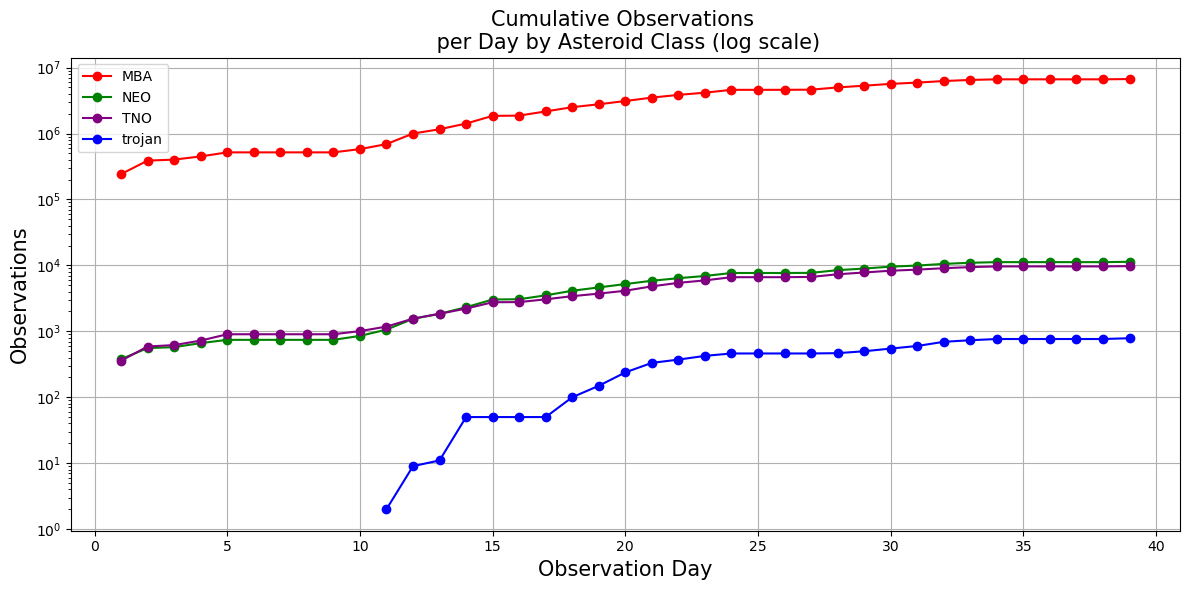

In [59]:
dfcopyRealTypes=dfrealtypes.copy()

#this makes line graphs from known asteroid observations

#change settings
cumulative=True 
firstID=False
log_scale=True
files = {# put a line in a comment to ignore that group
    'MBA': {'label': 'MBA', 'color': 'red'},
    'NEO': {'label': 'NEO', 'color': 'green'},
    'TNO': {'label': 'TNO', 'color': 'purple'},
    'trojan': {'label': 'trojan', 'color': 'blue'}
}
class_data = {}

for file, info in files.items():
    df = dfcopyRealTypes.query(f"type == '{file}'").copy()
    if firstID:
        df = df.drop_duplicates(subset='ObjID', keep='first')

    df['day'] = (df['fieldMJD_TAI']-60846).astype(int)
    
    daily_counts = df.groupby('day').size().reset_index(name='count')
    all_days = np.arange(1, 40)
    daily_counts = daily_counts.set_index('day').reindex(all_days, fill_value=np.nan).reset_index()
    daily_counts.rename(columns={'index': 'day'}, inplace=True)
    
    if cumulative:
        daily_counts['plot'] = daily_counts['count'].cumsum()
        daily_counts['plot'] = daily_counts['plot'].ffill()
    else:
        daily_counts['plot'] = daily_counts['count']
    
    class_data[info['label']] = {
        'day': daily_counts['day'],
        'plot': daily_counts['plot'],
        'color': info['color']
    }


plt.figure(figsize=(12, 6))

for label, data in class_data.items():
    plt.plot(data['day'], data['plot'], label=label, color=data['color'],marker='o', linestyle='-')

plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
title='Observations \n per Day by Asteroid Class'
if firstID:
    title='First-time ID '+title
if cumulative:
    title='Cumulative '+title
if log_scale:
    plt.yscale('log')
    title=title+' (log scale)'
plt.title(title,size=15)
plt.legend()
plt.grid(True)
plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

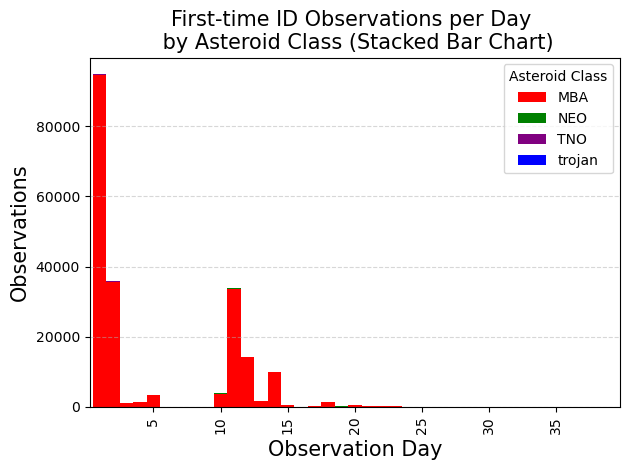

In [54]:
from functools import reduce

dfcopyRealTypes=dfrealtypes.copy()

#this makes stacked bar graphs from known asteroid observations

#change settings
cumulative=False 
firstID=True

files = { # put a line in a comment to ignore that group
    'MBA': 'MBA',
    'NEO': 'NEO',
    'TNO': 'TNO',
    'trojan': 'trojan' 
}
colors = {
    'MBA': 'red',
    'trojan': 'blue',
    'NEO': 'green',
    'TNO': 'purple'
}
all_counts = []

for file, class_name in files.items():
    df = dfcopyRealTypes.query(f"type == '{file}'").copy()
    df['mjd_day'] = (df['fieldMJD_TAI'] - 60846).astype(int)
    if firstID:
        first_seen = df.drop_duplicates(subset='ObjID', keep='first')
        daily = first_seen.groupby('mjd_day').size().reset_index(name=class_name)
    else:
        daily = df.groupby('mjd_day').size().reset_index(name=class_name)
    all_counts.append(daily)

df_merged = reduce(lambda left, right: pd.merge(left, right, on='mjd_day', how='outer'), all_counts)
df_merged = df_merged.fillna(0)

full_range = pd.RangeIndex(1, 40)
df_merged = df_merged.set_index('mjd_day').reindex(full_range, fill_value=0)

if cumulative:
    for class_name in files.values():
        df_merged[class_name] = df_merged[class_name].cumsum()

plt.figure(figsize=(14, 6))
if cumulative:
    df_merged.plot.area(color=[colors[c] for c in files.values()])
else:
    df_merged.plot(kind='bar', stacked=True, color=[colors[c] for c in files.values()], width=1.0)
plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
plt.title('Observations per Day by Asteroid Class \n (Stacked Bar Chart)',size=15)
if firstID:
    plt.title('First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
if cumulative:
    plt.title('Cumulative Observations per Day by \n Asteroid Class (Stacked Bar Chart)',size=15)
    if firstID:
        plt.title('Cumulative First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
plt.legend(title='Asteroid Class')
plt.grid(axis='y', linestyle='--', alpha=0.5)

if cumulative==False:
    xticks_interval = 5
    xticks = np.arange(4, 39, xticks_interval)
    plt.xticks(xticks)
plt.tight_layout()

In [8]:
##########
#########
########
#######
######
#####
####
###
##
#

In [10]:
# colors.csv has data about asteroid magnitude and colors
# replace the string with the file path
df_colors=pd.read_csv('~/epyc/users/nzoric/vsa/colors.csv')
# here, a column 'H_r' is added to simulation results by matching object IDs with the colors file
dfrealtypescolors=dfrealtypes.merge(df_colors[["H_r","ObjID"]],on="ObjID")

In [11]:
dfcn=pd.read_csv('~/epyc/users/nzoric/vsa/colors_NEO.csv')
dfcn

,ObjID,H_r,u-r,g-r,i-r,z-r,y-r,GS
0,N0000000,28.086852,1.265586,0.624898,-0.438042,-0.713093,-0.874789,0.15
1,N0000001,25.940727,1.553855,0.778647,-0.509508,-0.721094,-0.911049,0.15
2,N0000002,26.306272,1.238824,0.719037,-0.503907,-0.737500,-0.911035,0.15
3,N0000003,24.032444,1.369019,0.739907,-0.473577,-0.656195,-0.793254,0.15
4,N0000004,26.409430,1.657760,0.796799,-0.516441,-0.730805,-0.972929,0.15
...,...,...,...,...,...,...,...,...
6057394,N05c6db2,26.375828,1.543218,0.779647,-0.500710,-0.702493,-0.958022,0.15
6057395,N05c6db3,27.231118,1.568210,0.776080,-0.509711,-0.735559,-1.039625,0.15
6057396,N05c6db4,26.025807,1.551973,0.762792,-0.506288,-0.753428,-0.994537,0.15
6057397,N05c6db5,30.141780,1.412360,0.622818,-0.430083,-0.721165,-0.963002,0.15


In [12]:
df_neo = pd.read_csv('~/epyc/users/nzoric/vsa/e2e_neo.csv')
df_neo=df_neo.merge(dfcn[["H_r","ObjID"]],on="ObjID")
df_neo.head()

,ObjID,fieldMJD_TAI,fieldRA_deg,fieldDec_deg,RA_deg,Dec_deg,astrometricSigma_deg,optFilter,trailedSourceMag,trailedSourceMagSigma,fiveSigmaDepth_mag,phase_deg,Range_LTC_km,RangeRate_LTC_km_s,Obj_Sun_LTC_km,H_r
0,N00005e2,60857.364893,300.001406,-19.039630,300.739534,-18.201189,0.000020,i,23.479581,0.158597,24.016603,16.507401,3.033487e+07,-3.249738,1.809295e+08,26.207993
1,N00005e2,60859.216474,302.535495,-16.373026,301.981506,-17.718317,0.000032,i,23.379614,0.180307,23.712612,16.153496,2.980242e+07,-3.246202,1.804935e+08,26.207993
2,N00005e2,60861.372774,302.213764,-17.474600,303.405291,-17.139059,0.000109,z,23.196739,0.411607,22.406537,15.726753,2.925198e+07,-2.506420,1.800407e+08,26.207993
3,N0000104,60864.340087,14.111731,-0.976359,13.361764,-0.792904,0.000007,z,21.170227,0.040007,23.115164,31.194716,2.397322e+08,-31.745058,2.928890e+08,18.085387
4,N0000104,60865.348176,12.799936,-0.414708,13.588261,-0.675875,0.000009,z,21.224100,0.057882,22.655453,31.260392,2.369865e+08,-31.745584,2.920525e+08,18.085387


array([[<Axes: title={'center': 'H_r'}>]], dtype=object)

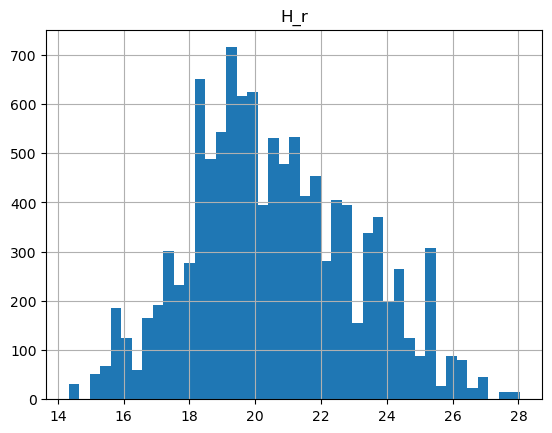

In [13]:
dfrealtypescolors.query("type=='NEO'").hist('H_r', bins='fd')

array([[<Axes: title={'center': 'H_r'}>]], dtype=object)

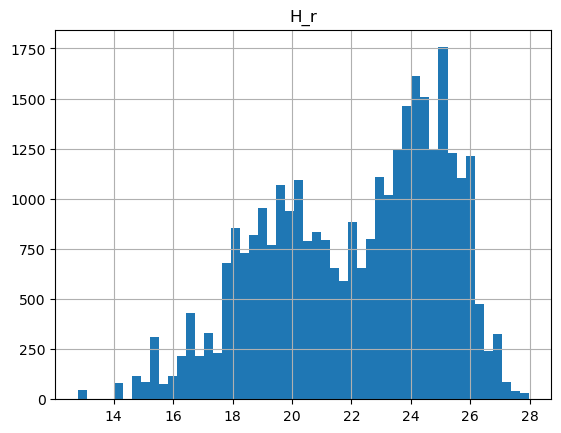

In [14]:
df_neo.hist('H_r', bins='fd')

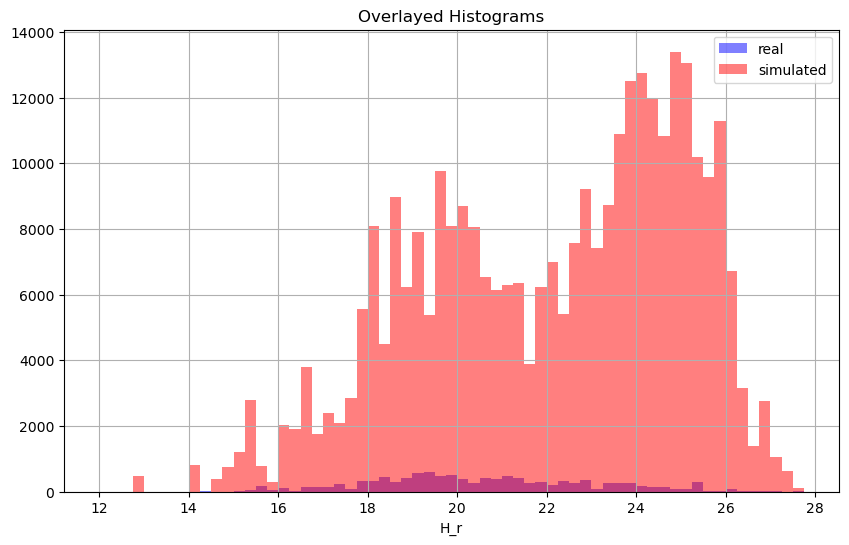

In [15]:
dfr2_neo = dfrealtypescolors.query("type == 'NEO'")['H_r']
df3_data = df_neo['H_r']

df3_data10 = np.tile(df3_data, 10)
# Plotting the histograms
plt.figure(figsize=(10, 6))
bins=np.arange(12, 28, 0.25)
# Histogram for dfr2_neo 
plt.hist(dfr2_neo, bins=bins, alpha=0.5, label='real', color='blue')

# Histogram for df3 
plt.hist(df3_data10, bins=bins, alpha=0.5, label='simulated', color='red')

# Adding titles and labels
plt.title('Overlayed Histograms')
plt.xlabel('H_r')

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [16]:
"""import sqlite3
conn=sqlite3.connect("sv_20250729.db")
dfobs=pd.read_sql_query("SELECT * FROM observations", conn)
conn.close()
dfobs.query("observationStartMJD <60886")['fiveSigmaDepth'].hist(bins='fd',density=True)#, cumulative=True, )"""

'import sqlite3\nconn=sqlite3.connect("sv_20250729.db")\ndfobs=pd.read_sql_query("SELECT * FROM observations", conn)\nconn.close()\ndfobs.query("observationStartMJD <60886")[\'fiveSigmaDepth\'].hist(bins=\'fd\',density=True)#, cumulative=True, )'